In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt


from fbpinns.domains import RectangularDomainND
from fbpinns.problems import Problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import PINNTrainer, FBPINNTrainer

In [2]:
class Heat(Problem):
    @staticmethod
    def init_params(alpha=0.4, n=2, L=1):
        
        static_params = {
            'dims': (1,2),
            'alpha': alpha,
            'n': n,
            'L': L
        }
        return static_params, {}
    
    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,()), #u
            (0,(1,)), #ut
            (0,(0,0)) #uxx
        )
        
        return [
            [x_batch_phys, required_ujs_phys],
        ]

    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        ##THIS ONLY WORKS IF n/L = 2k!!!
        x, t = x_batch[:,0:1], x_batch[:,1:2]
        n = all_params['static']['problem']['n']
        L = all_params['static']['problem']['L']
        return jnp.sin(n * jnp.pi * x/L) + x*(1-x)*t*u
        
    @staticmethod
    def loss_fn(all_params, constraints):
        alpha = all_params['static']['problem']['alpha']
        _, u, ut, uxx = constraints[0]
        physl = jnp.mean((ut - alpha*uxx)**2)

        return physl

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        x, t = x_batch[:,0:1], x_batch[:, 1:2]
        alpha = all_params['static']['problem']['alpha']
        n = all_params['static']['problem']['n']
        L = all_params['static']['problem']['L']
        ex = jnp.exp(-n**2 * jnp.pi**2 * alpha * t / L**2)
        sin = jnp.sin(n * jnp.pi * x/L)
        return ex * sin

In [3]:
subdomain_xs = [jnp.linspace(-1, 1, 10), jnp.linspace(0, 1, 5)]
subdomain_ws = get_subdomain_ws(subdomain_xs, 2.7)

c = Constants(
    run = "null",
    domain=RectangularDomainND,
    domain_init_kwargs=dict(
        xmin=np.array([-1., 0.]),
        xmax=np.array([1., 1.]),
    ),
    problem=Heat,
    problem_init_kwargs=dict(alpha=0.4, n=1, L=1),
    decomposition = RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs = subdomain_xs,
        subdomain_ws = subdomain_ws,
        unnorm=(0., 1.),
    ),
    network=FCN,
    network_init_kwargs=dict(
        layer_sizes = [2,16,1],
    ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    summary_freq = 500,
    test_freq = 500,
    ns = ((40,40),),
    n_test = (100,100),
    n_steps = 50000,
    optimiser_kwargs=dict(learning_rate=1e-4),
    show_figures=True);

[INFO] 2024-05-10 14:59:11 - <fbpinns.constants.Constants object at 0x7d96a83e1e80>
run: null
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-1.,  0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.Heat'>
problem_init_kwargs: {'alpha': 0.4, 'n': 1, 'L': 1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [Array([-1.        , -0.7777778 , -0.5555556 , -0.33333328, -0.11111113,
        0.11111116,  0.33333337,  0.5555556 ,  0.7777778 ,  1.        ],      dtype=float32), Array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float32)], 'subdomain_ws': [array([0.5999998, 0.5999998, 0.5999998, 0.5999998, 0.5999998, 0.5999998,
       0.5999998, 0.5999998, 0.5999998, 0.5999998], dtype=float32), array([0.675, 0.675, 0.675, 0.675, 0.675], dtype=float32)], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [2, 16, 1]}
n_steps: 50000
scheduler

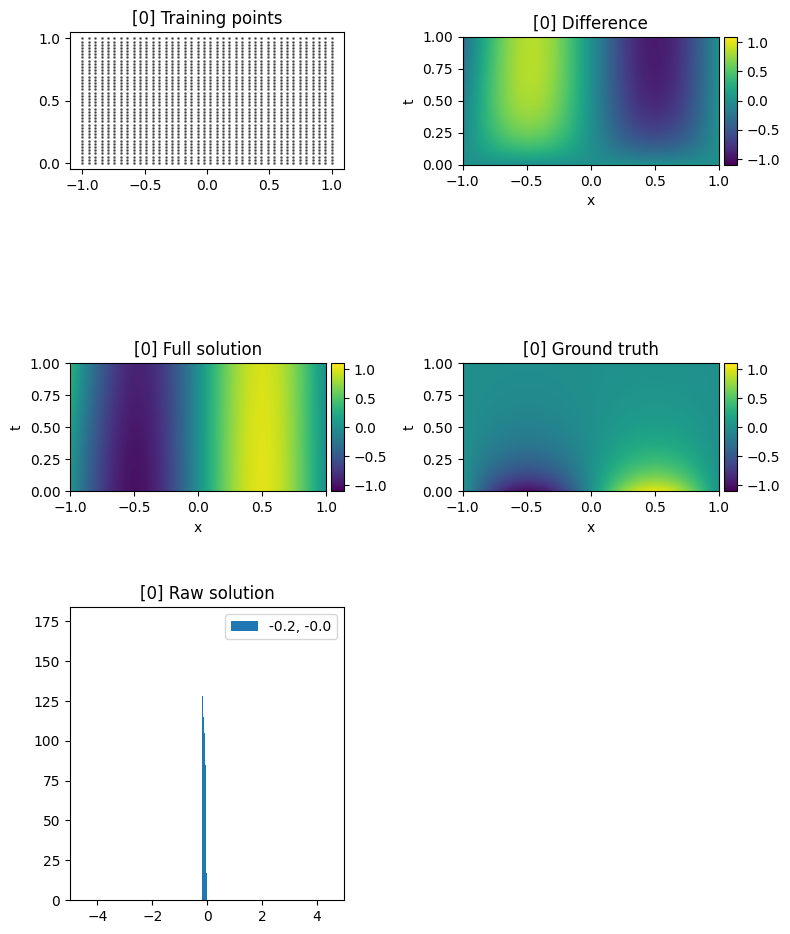

[INFO] 2024-05-10 14:59:13 - [i: 500/50000] loss: 5.9483 rate: 4625.8 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:14 - [i: 1000/50000] loss: 4.9743 rate: 4980.6 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:14 - [i: 1500/50000] loss: 4.1991 rate: 6895.8 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:14 - [i: 2000/50000] loss: 3.5338 rate: 6920.2 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:14 - [i: 2500/50000] loss: 2.9294 rate: 6968.0 elapsed: 0.00 hr null


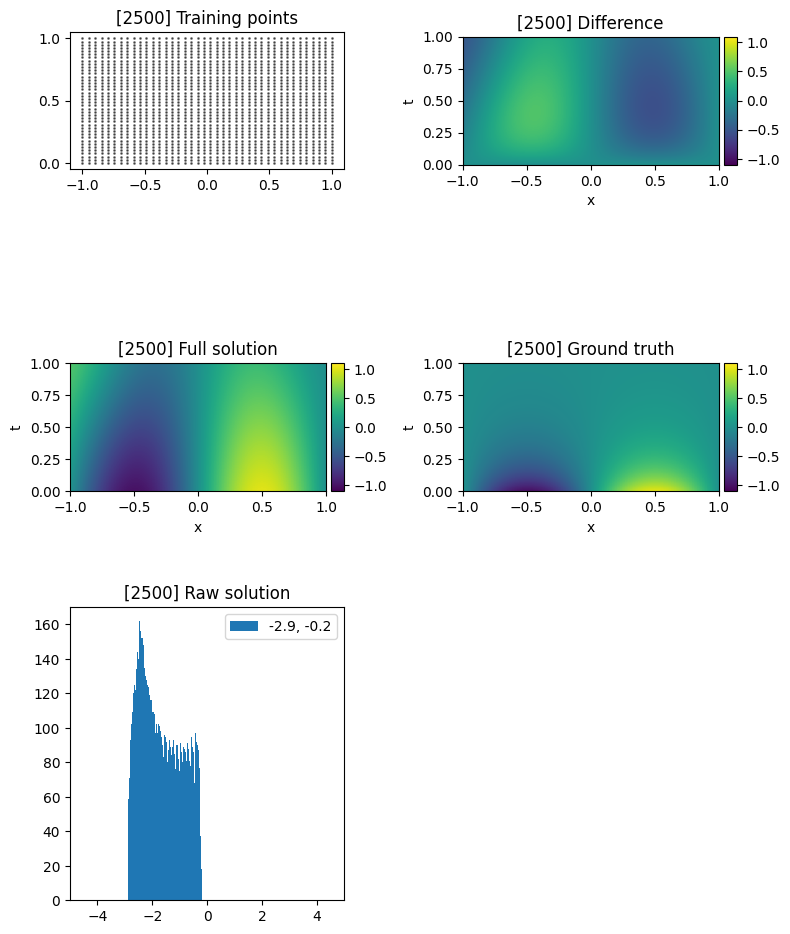

[INFO] 2024-05-10 14:59:15 - [i: 3000/50000] loss: 2.4077 rate: 6971.1 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:15 - [i: 3500/50000] loss: 1.9982 rate: 6981.0 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:15 - [i: 4000/50000] loss: 1.7046 rate: 6979.5 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:15 - [i: 4500/50000] loss: 1.5049 rate: 6975.6 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:15 - [i: 5000/50000] loss: 1.3608 rate: 6975.0 elapsed: 0.00 hr null


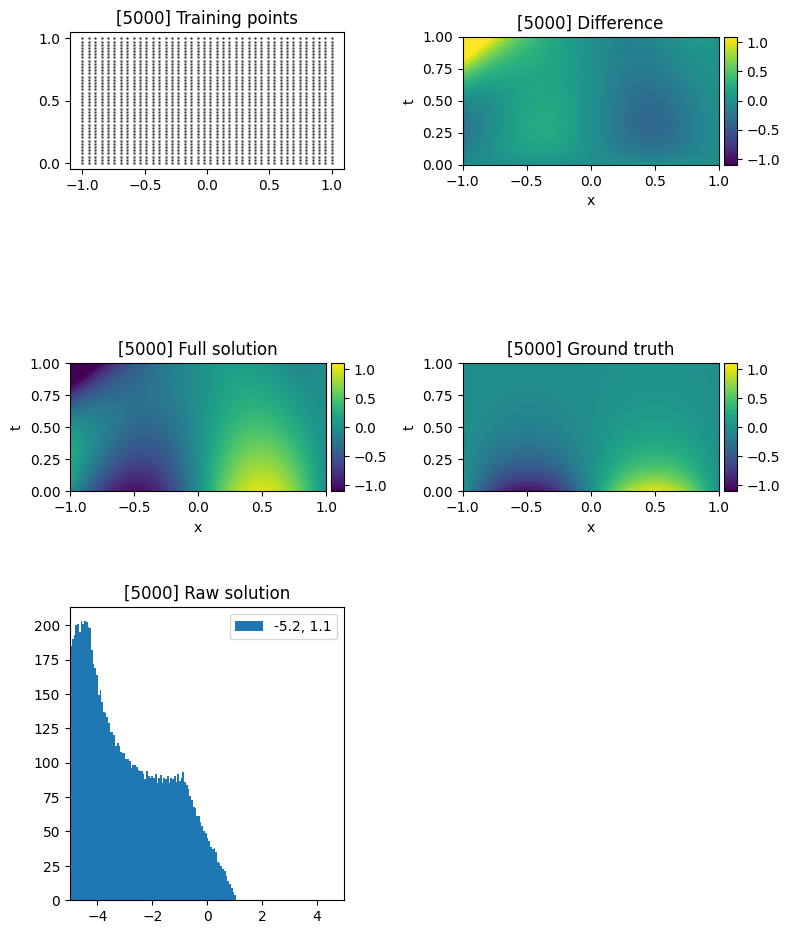

[INFO] 2024-05-10 14:59:16 - [i: 5500/50000] loss: 1.2393 rate: 6977.1 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:16 - [i: 6000/50000] loss: 1.1264 rate: 6984.6 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:16 - [i: 6500/50000] loss: 1.0183 rate: 6992.6 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:16 - [i: 7000/50000] loss: 0.9118 rate: 6984.1 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:16 - [i: 7500/50000] loss: 0.8049 rate: 6980.3 elapsed: 0.00 hr null


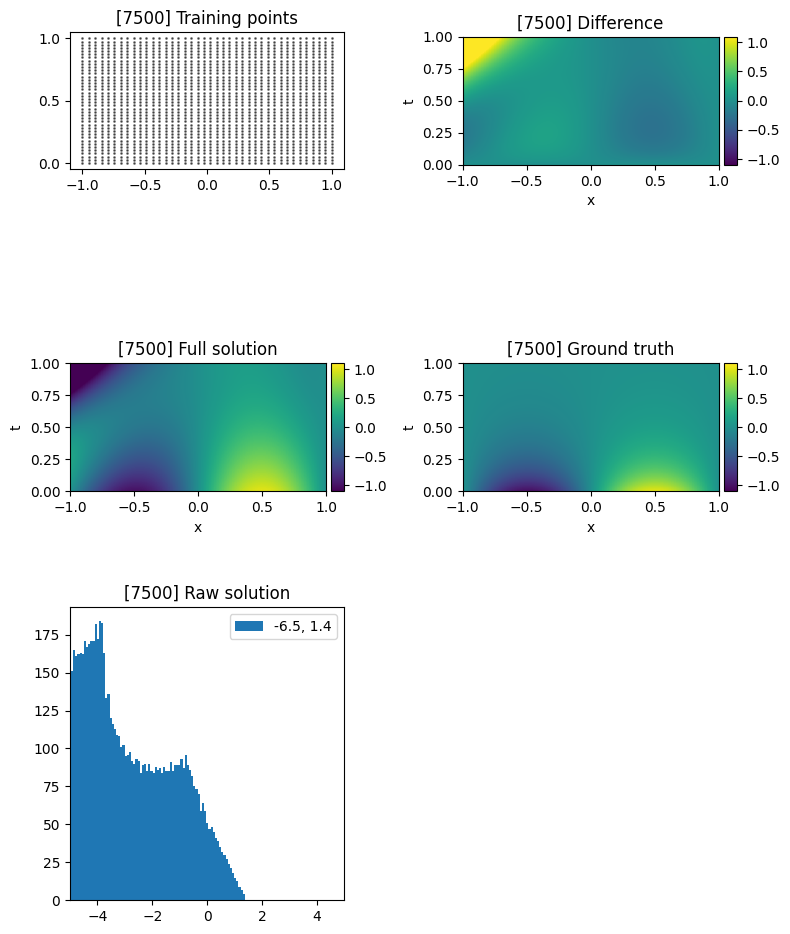

[INFO] 2024-05-10 14:59:17 - [i: 8000/50000] loss: 0.7009 rate: 6950.9 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:17 - [i: 8500/50000] loss: 0.6030 rate: 6998.9 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:17 - [i: 9000/50000] loss: 0.5106 rate: 7000.9 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:17 - [i: 9500/50000] loss: 0.4273 rate: 6997.9 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:17 - [i: 10000/50000] loss: 0.3583 rate: 6990.4 elapsed: 0.00 hr null


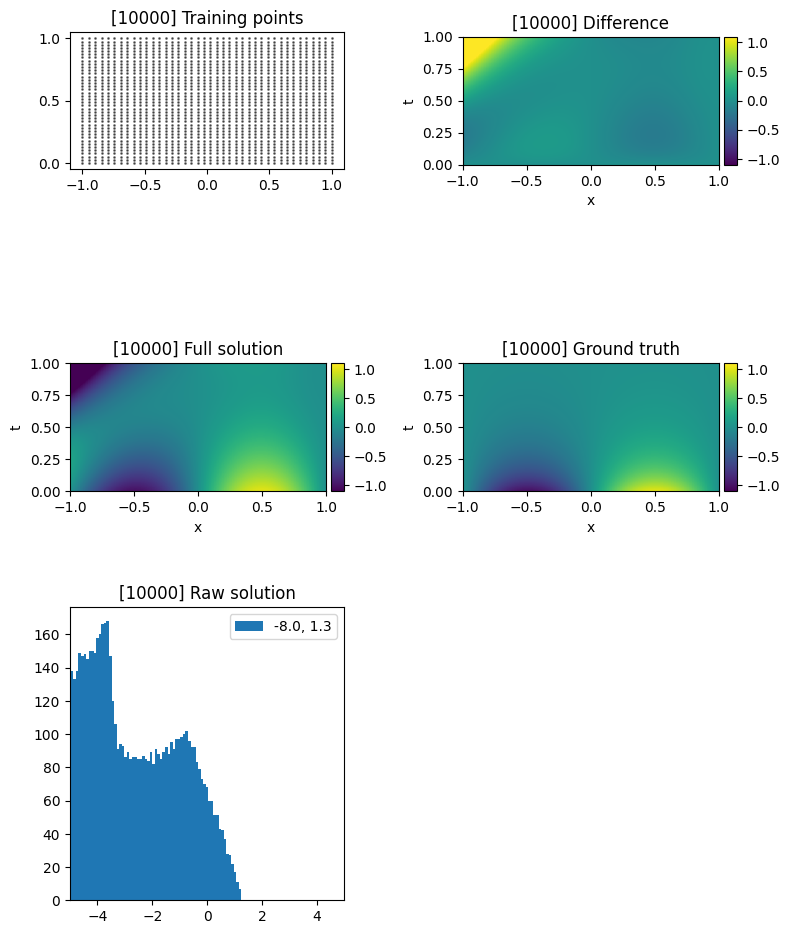

[INFO] 2024-05-10 14:59:18 - [i: 10500/50000] loss: 0.3024 rate: 6979.4 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:18 - [i: 11000/50000] loss: 0.2576 rate: 6996.0 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:18 - [i: 11500/50000] loss: 0.2221 rate: 7009.4 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:18 - [i: 12000/50000] loss: 0.1927 rate: 6997.3 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:18 - [i: 12500/50000] loss: 0.1679 rate: 7000.1 elapsed: 0.00 hr null


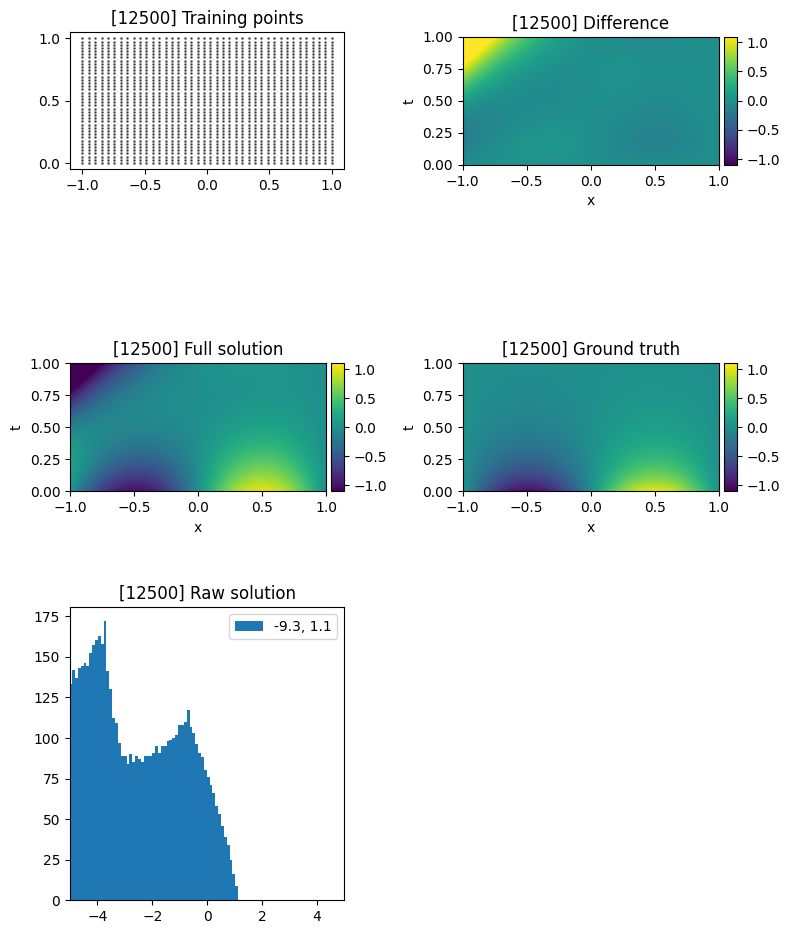

[INFO] 2024-05-10 14:59:19 - [i: 13000/50000] loss: 0.1474 rate: 6957.2 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:19 - [i: 13500/50000] loss: 0.1309 rate: 6993.9 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:19 - [i: 14000/50000] loss: 0.1175 rate: 7004.1 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:19 - [i: 14500/50000] loss: 0.1060 rate: 6964.5 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:19 - [i: 15000/50000] loss: 0.0957 rate: 6977.6 elapsed: 0.00 hr null


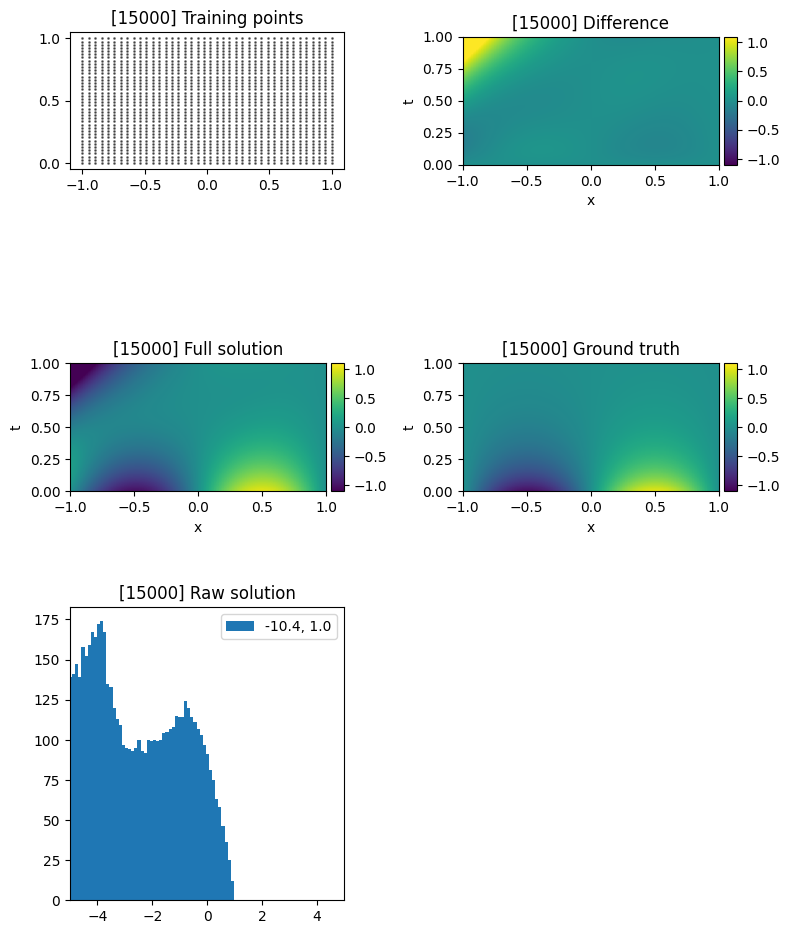

[INFO] 2024-05-10 14:59:20 - [i: 15500/50000] loss: 0.0862 rate: 6967.4 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:20 - [i: 16000/50000] loss: 0.0770 rate: 7005.8 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:20 - [i: 16500/50000] loss: 0.0680 rate: 6997.8 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:20 - [i: 17000/50000] loss: 0.0597 rate: 6976.6 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:20 - [i: 17500/50000] loss: 0.0523 rate: 7005.1 elapsed: 0.00 hr null


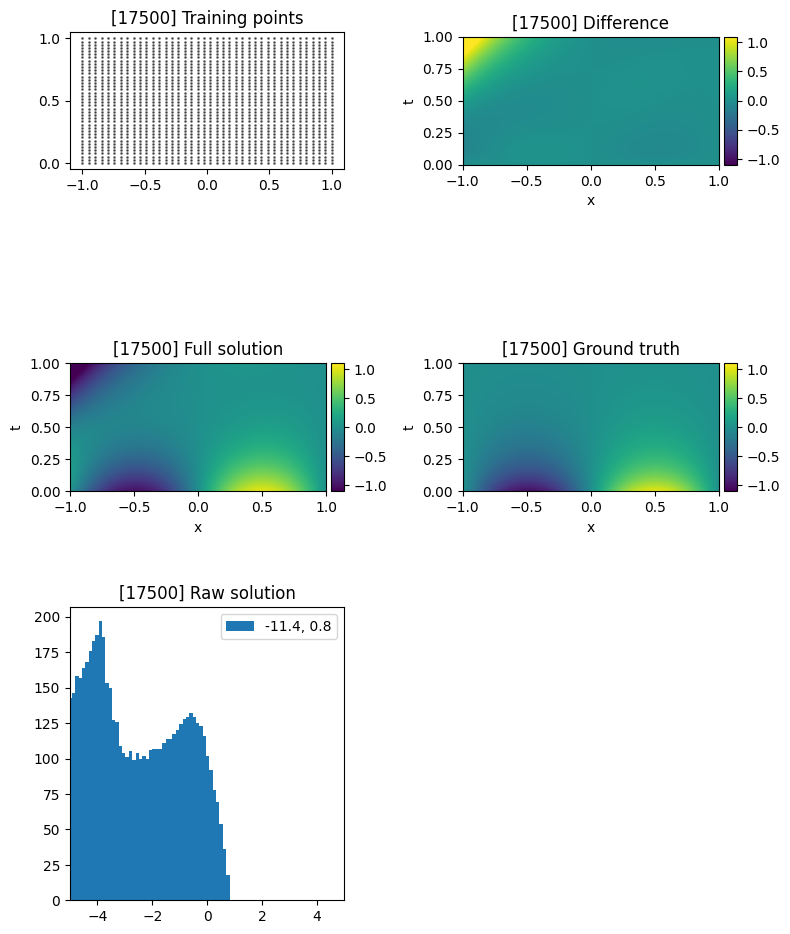

[INFO] 2024-05-10 14:59:21 - [i: 18000/50000] loss: 0.0459 rate: 6966.9 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:21 - [i: 18500/50000] loss: 0.0405 rate: 6985.7 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:21 - [i: 19000/50000] loss: 0.0357 rate: 7016.7 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:21 - [i: 19500/50000] loss: 0.0313 rate: 6981.8 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:22 - [i: 20000/50000] loss: 0.0273 rate: 6971.4 elapsed: 0.00 hr null


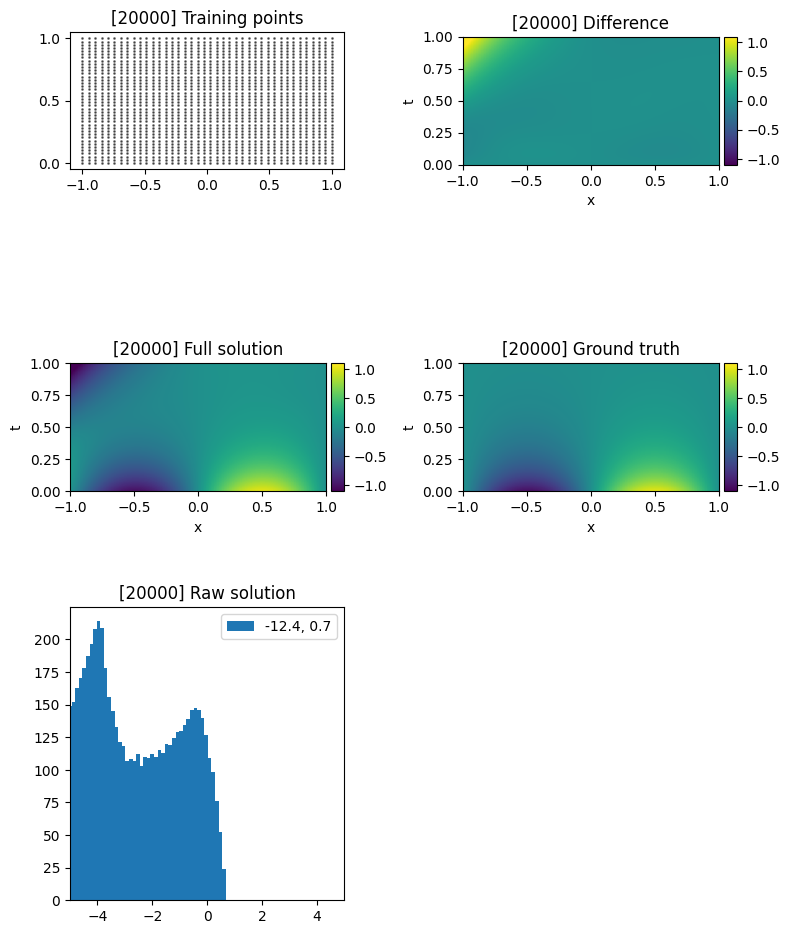

[INFO] 2024-05-10 14:59:22 - [i: 20500/50000] loss: 0.0237 rate: 6979.1 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:22 - [i: 21000/50000] loss: 0.0207 rate: 6972.9 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:22 - [i: 21500/50000] loss: 0.0181 rate: 7002.3 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:22 - [i: 22000/50000] loss: 0.0158 rate: 6995.9 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:23 - [i: 22500/50000] loss: 0.0139 rate: 6975.6 elapsed: 0.00 hr null


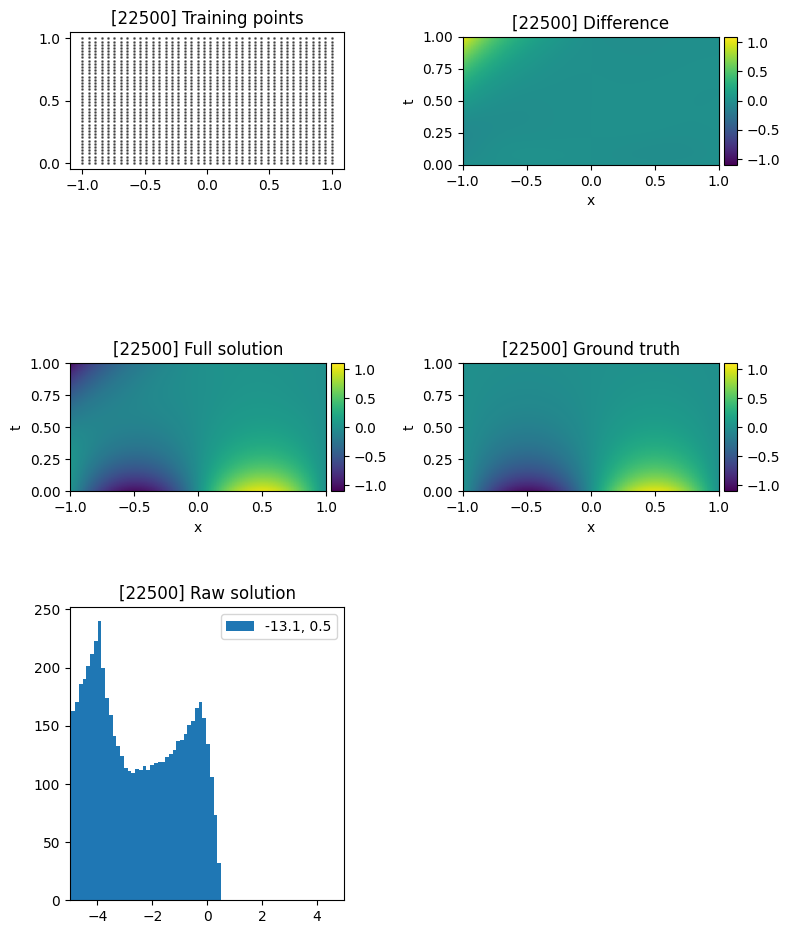

[INFO] 2024-05-10 14:59:23 - [i: 23000/50000] loss: 0.0121 rate: 6970.7 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:24 - [i: 23500/50000] loss: 0.0104 rate: 6973.3 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:24 - [i: 24000/50000] loss: 0.0089 rate: 6986.6 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:24 - [i: 24500/50000] loss: 0.0076 rate: 7000.7 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:24 - [i: 25000/50000] loss: 0.0065 rate: 6993.8 elapsed: 0.00 hr null


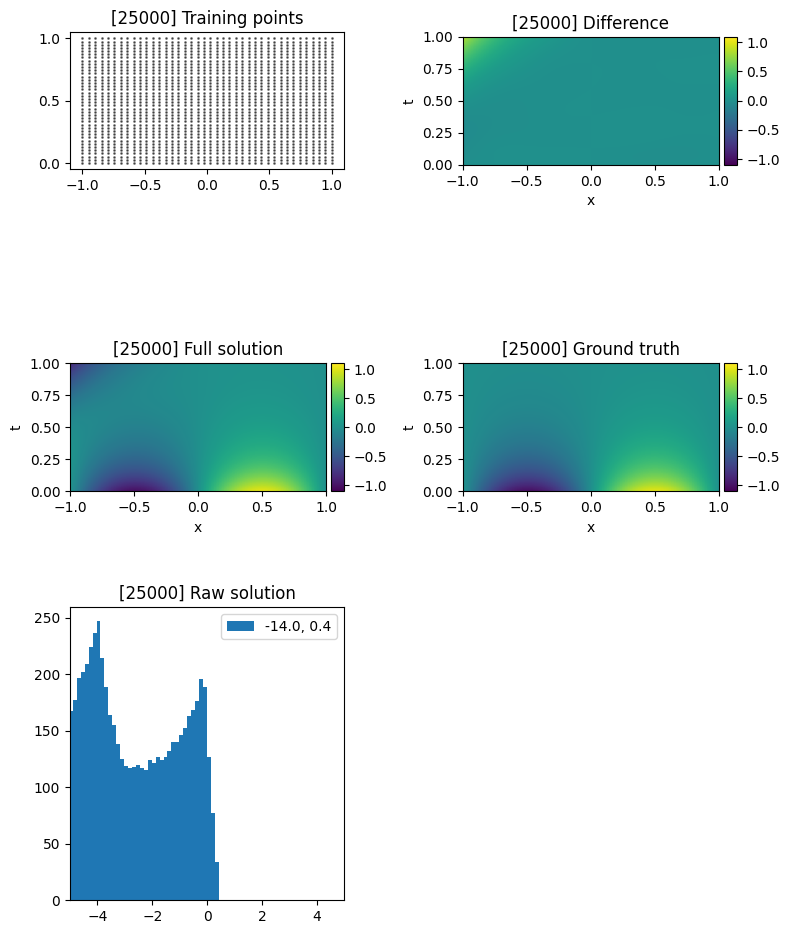

[INFO] 2024-05-10 14:59:24 - [i: 25500/50000] loss: 0.0057 rate: 6975.2 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:25 - [i: 26000/50000] loss: 0.0050 rate: 7010.1 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:25 - [i: 26500/50000] loss: 0.0044 rate: 6983.4 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:25 - [i: 27000/50000] loss: 0.0039 rate: 6979.9 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:25 - [i: 27500/50000] loss: 0.0034 rate: 6991.8 elapsed: 0.00 hr null


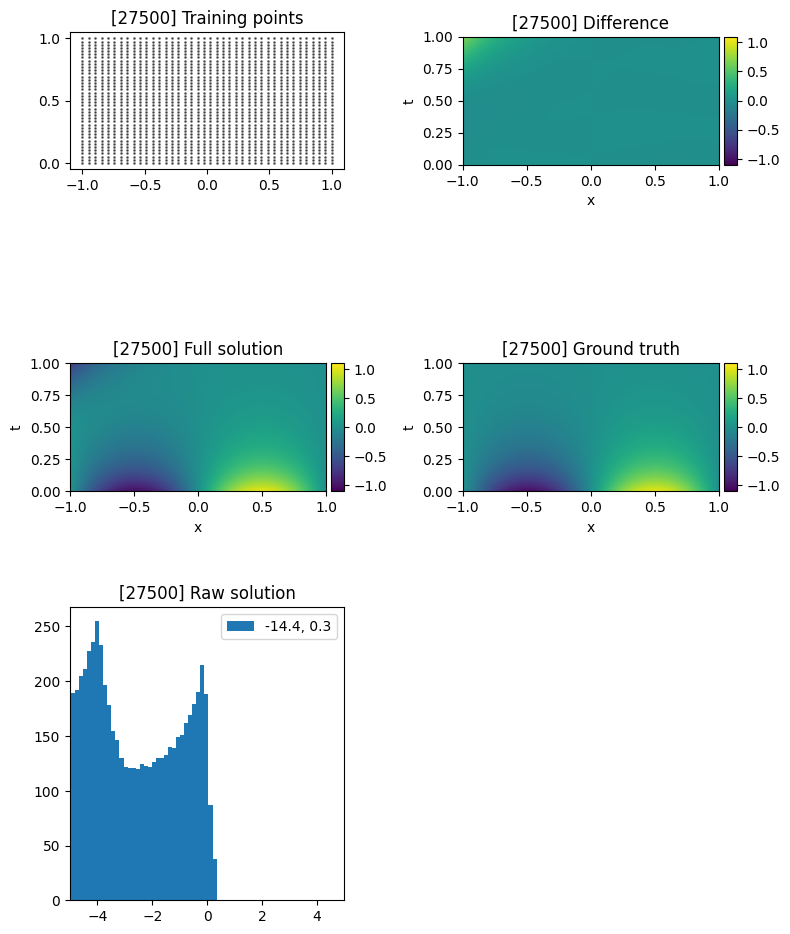

[INFO] 2024-05-10 14:59:26 - [i: 28000/50000] loss: 0.0030 rate: 6975.8 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:26 - [i: 28500/50000] loss: 0.0026 rate: 7001.0 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:26 - [i: 29000/50000] loss: 0.0022 rate: 6992.3 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:26 - [i: 29500/50000] loss: 0.0019 rate: 6975.2 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:26 - [i: 30000/50000] loss: 0.0016 rate: 6982.6 elapsed: 0.00 hr null


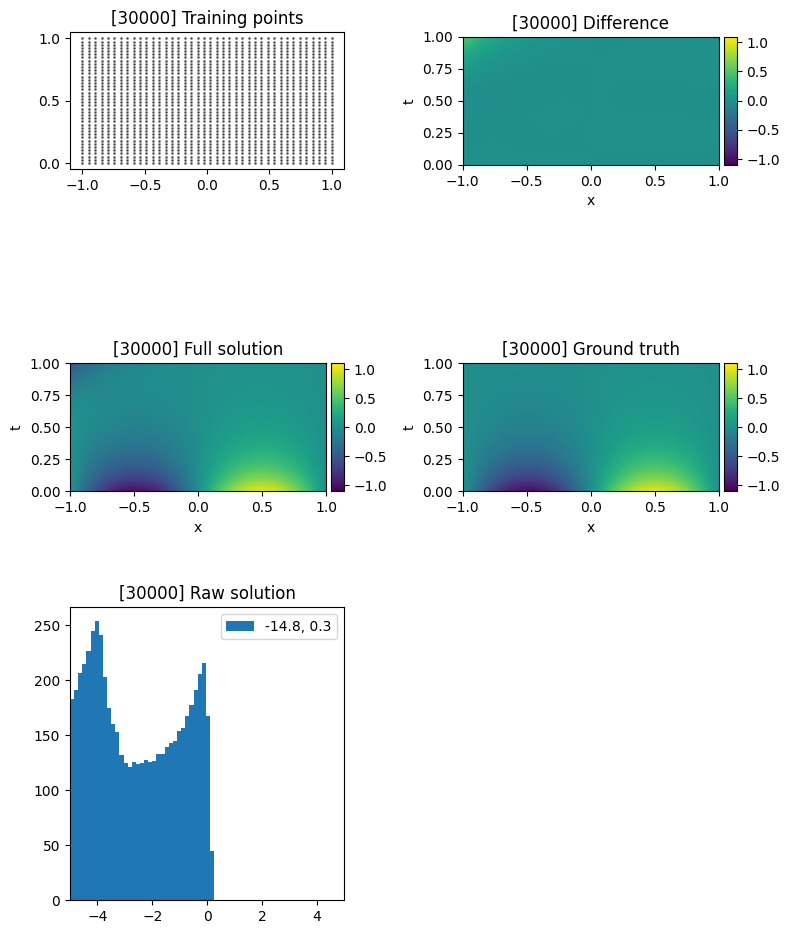

[INFO] 2024-05-10 14:59:27 - [i: 30500/50000] loss: 0.0014 rate: 6978.5 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:27 - [i: 31000/50000] loss: 0.0012 rate: 6972.9 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:27 - [i: 31500/50000] loss: 0.0010 rate: 6969.5 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:27 - [i: 32000/50000] loss: 0.0009 rate: 6980.2 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:27 - [i: 32500/50000] loss: 0.0008 rate: 6985.3 elapsed: 0.00 hr null


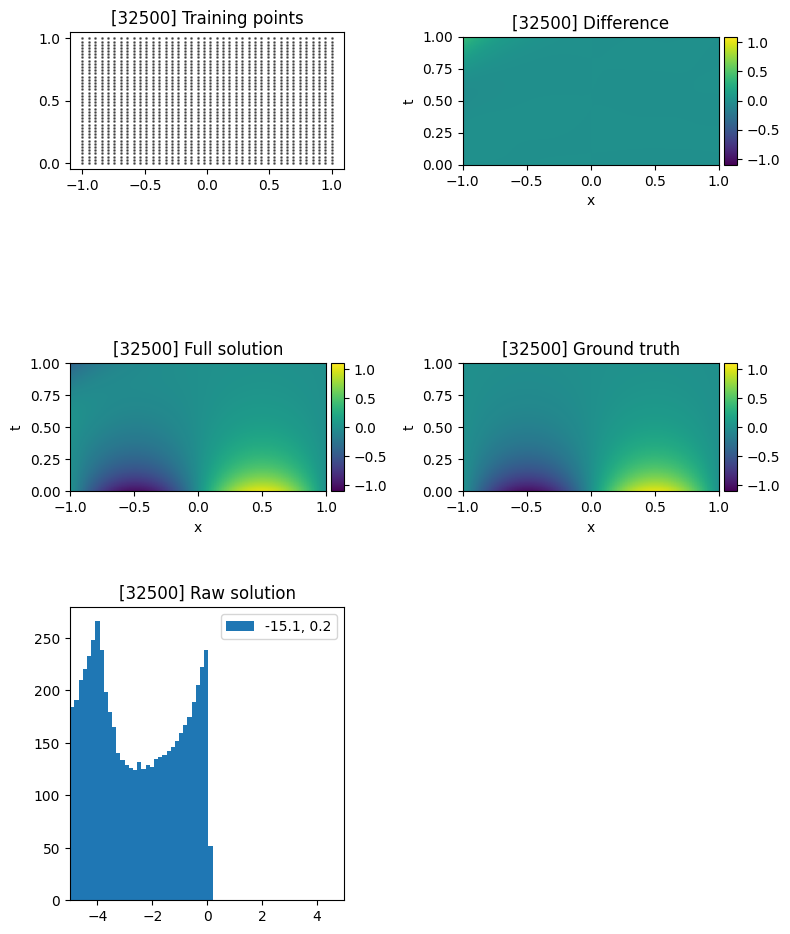

[INFO] 2024-05-10 14:59:28 - [i: 33000/50000] loss: 0.0007 rate: 6982.3 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:28 - [i: 33500/50000] loss: 0.0006 rate: 6951.9 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:28 - [i: 34000/50000] loss: 0.0005 rate: 6983.8 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:28 - [i: 34500/50000] loss: 0.0005 rate: 6982.4 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:28 - [i: 35000/50000] loss: 0.0004 rate: 6993.2 elapsed: 0.00 hr null


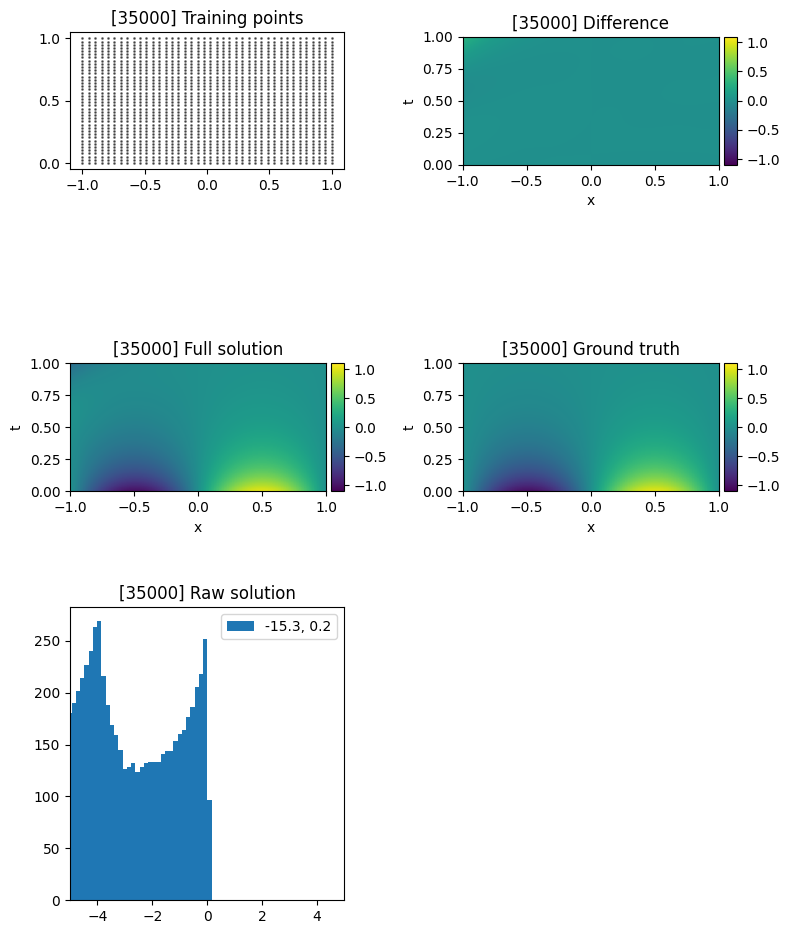

[INFO] 2024-05-10 14:59:29 - [i: 35500/50000] loss: 0.0004 rate: 6941.1 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:29 - [i: 36000/50000] loss: 0.0003 rate: 6959.6 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:29 - [i: 36500/50000] loss: 0.0003 rate: 6992.5 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:29 - [i: 37000/50000] loss: 0.0003 rate: 6998.8 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:29 - [i: 37500/50000] loss: 0.0003 rate: 6976.9 elapsed: 0.00 hr null


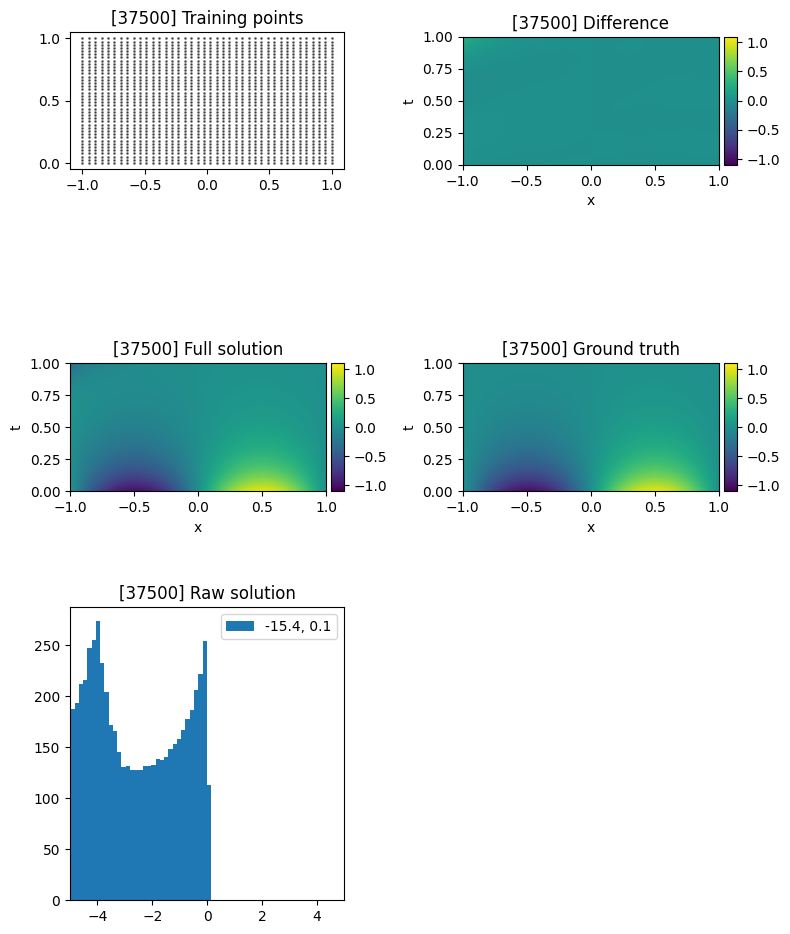

[INFO] 2024-05-10 14:59:30 - [i: 38000/50000] loss: 0.0002 rate: 6985.9 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:30 - [i: 38500/50000] loss: 0.0002 rate: 7001.4 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:30 - [i: 39000/50000] loss: 0.0002 rate: 6980.4 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:30 - [i: 39500/50000] loss: 0.0002 rate: 6982.5 elapsed: 0.00 hr null
[INFO] 2024-05-10 14:59:30 - [i: 40000/50000] loss: 0.0002 rate: 6983.8 elapsed: 0.00 hr null


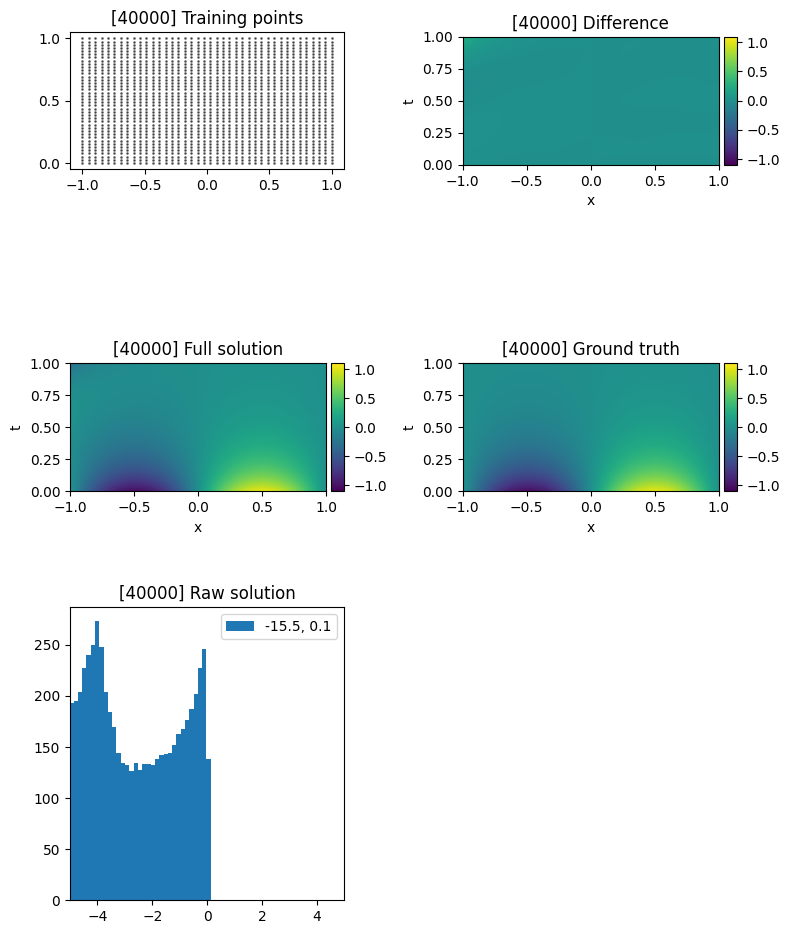

[INFO] 2024-05-10 14:59:31 - [i: 40500/50000] loss: 0.0002 rate: 6966.9 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:31 - [i: 41000/50000] loss: 0.0002 rate: 7004.8 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:31 - [i: 41500/50000] loss: 0.0002 rate: 7003.0 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:31 - [i: 42000/50000] loss: 0.0002 rate: 6995.5 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:31 - [i: 42500/50000] loss: 0.0002 rate: 6994.3 elapsed: 0.01 hr null


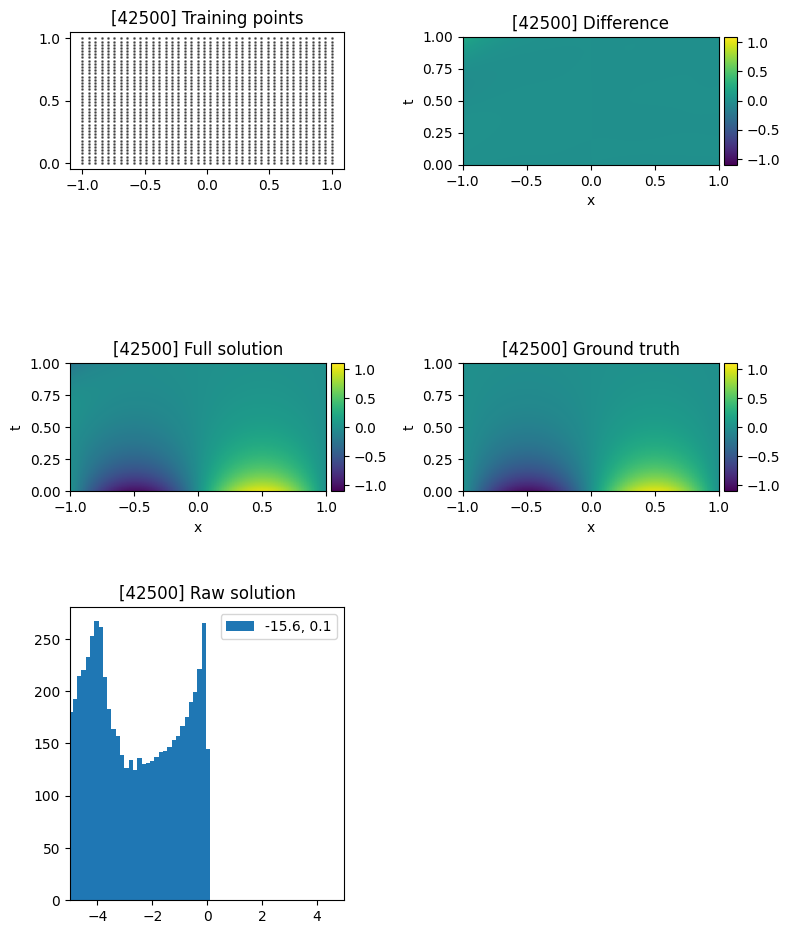

[INFO] 2024-05-10 14:59:32 - [i: 43000/50000] loss: 0.0001 rate: 7003.7 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:32 - [i: 43500/50000] loss: 0.0001 rate: 6992.9 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:32 - [i: 44000/50000] loss: 0.0001 rate: 7014.9 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:32 - [i: 44500/50000] loss: 0.0001 rate: 7002.8 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:32 - [i: 45000/50000] loss: 0.0001 rate: 7004.8 elapsed: 0.01 hr null


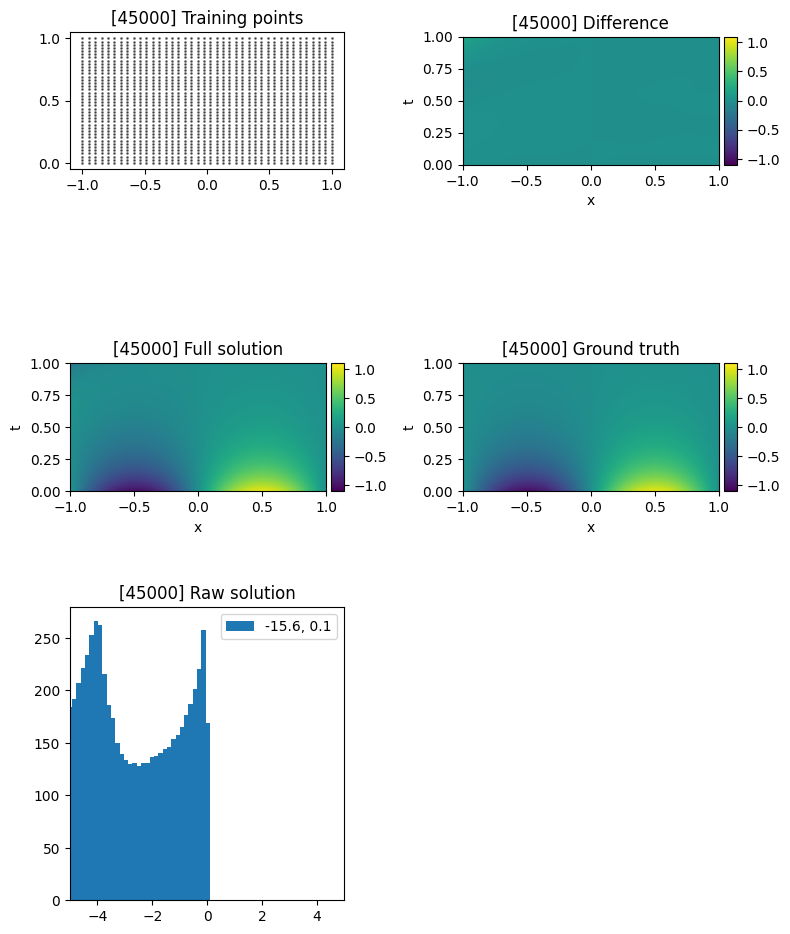

[INFO] 2024-05-10 14:59:33 - [i: 45500/50000] loss: 0.0001 rate: 6992.2 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:33 - [i: 46000/50000] loss: 0.0001 rate: 6991.3 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:33 - [i: 46500/50000] loss: 0.0001 rate: 6972.1 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:33 - [i: 47000/50000] loss: 0.0001 rate: 6991.2 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:33 - [i: 47500/50000] loss: 0.0001 rate: 6986.6 elapsed: 0.01 hr null


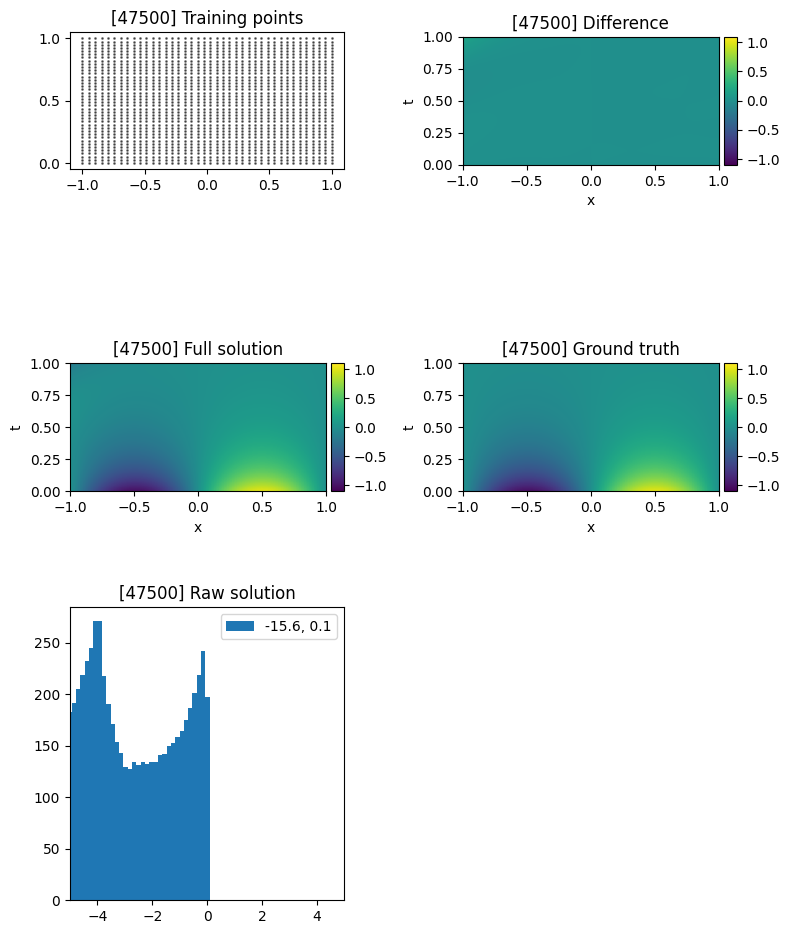

[INFO] 2024-05-10 14:59:34 - [i: 48000/50000] loss: 0.0001 rate: 6992.5 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:34 - [i: 48500/50000] loss: 0.0001 rate: 7007.0 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:34 - [i: 49000/50000] loss: 0.0001 rate: 6990.0 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:34 - [i: 49500/50000] loss: 0.0001 rate: 6987.0 elapsed: 0.01 hr null
[INFO] 2024-05-10 14:59:35 - [i: 50000/50000] loss: 0.0001 rate: 6992.2 elapsed: 0.01 hr null


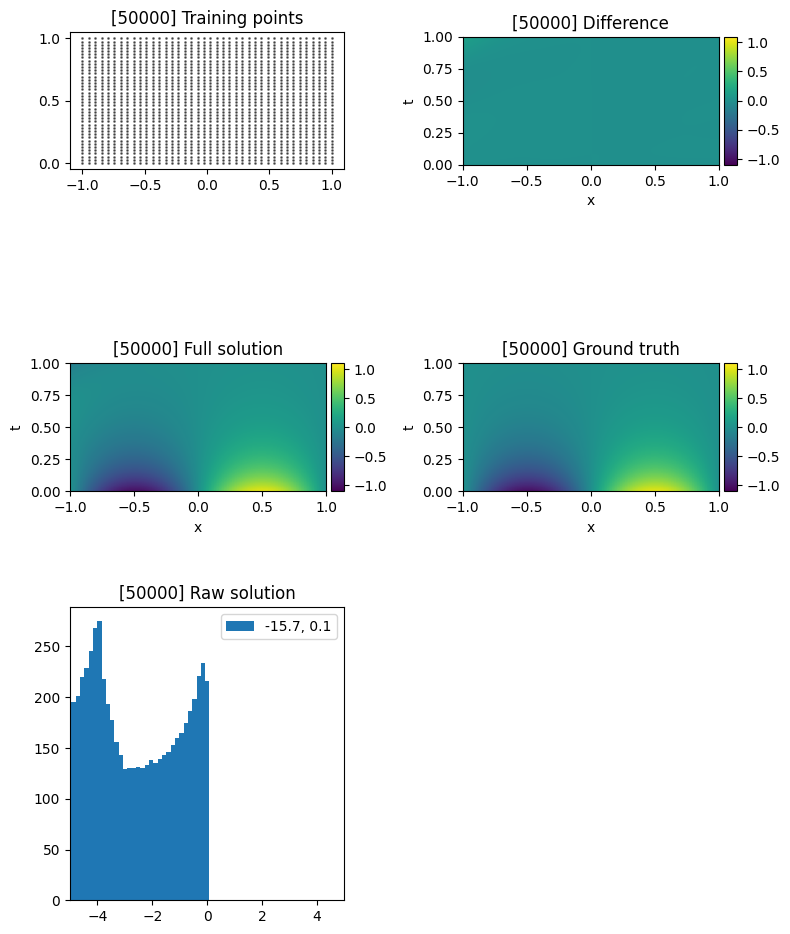

[INFO] 2024-05-10 14:59:35 - [i: 50000/50000] Training complete


In [4]:
## Они оба работают!!
run = PINNTrainer(c)
all_params = run.train()

In [7]:
all_params

{'static': {'domain': {'xd': 2,
   'xmin': Array([-1.,  0.], dtype=float32),
   'xmax': Array([1., 1.], dtype=float32)},
  'problem': {'dims': (1, 2), 'alpha': 0.4, 'n': 1, 'L': 1}},
 'trainable': {'network': {'subdomain': {'layers': [(Array([[ 1.7427938 ,  0.08545688],
             [-1.5252541 ,  0.3749144 ],
             [ 0.01176454, -1.5980821 ],
             [ 1.2811571 ,  0.5273769 ],
             [ 1.2145157 , -1.4745827 ],
             [-2.1973538 , -0.50843585],
             [ 1.6484462 ,  0.2080179 ],
             [ 2.2360837 , -1.1018671 ],
             [ 2.2163844 ,  0.21131572],
             [ 0.43607858,  1.5228789 ],
             [-0.60342646,  0.58759284],
             [ 1.5262359 , -0.7526633 ],
             [ 1.8848594 , -0.08756769],
             [ 0.8470468 ,  0.7473538 ],
             [-1.0943217 ,  2.9311905 ],
             [-1.6477015 ,  0.42148194]], dtype=float32),
      Array([ 0.59761274, -0.57807624, -1.5197288 , -0.02813349, -1.6959577 ,
             -2.274